In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from HyperNet import CustomHyperNet, CustomHyperConvLayer
from MNISTModel import MNISTHyperNetModel, StandardCNNModel
import matplotlib.pyplot as plt

# HYPERNETWORK

### INTRODUCTIOIN

**Hipernetworki** lub w skrócie **hipernety** to sieci neuronowe, które generują wagi dla innej sieci neuronowej, znanej jako sieć docelowa.

Kluczowe cechy i zalety hipernetów, które oferują aplikacje w różnych ustawieniach problemów:

* Soft weight sharing: Hipernetworki można trenować do generowania wag wielu DNN do rozwiązywania powiązanych zadań.

* Dynamic architectures: Hipernetworki mogą być używane do generowania wag sieci o architekturze dynamicznej, w której liczba warstw lub struktura sieci zmienia się podczas szkolenia lub wnioskowania. Może to być szczególnie przydatne w przypadku zadań, w których docelowa struktura sieci nie jest znana w czasie szkolenia.

* Data-adaptive DNN: w przeciwieństwie do standardowego DNN, którego wagi są ustalane w czasie wnioskowania, HyperDNN można opracować w celu generowania sieci docelowej dostosowanej do potrzeb danych. W takich przypadkach hipernety są uwarunkowane danymi wejściowymi w celu dostosowania się do danych.

* Uncertainty quantification: Hipernety mogą skutecznie trenować DNN ktore świadome o niepewności, wykorzystując techniki jak multiple inputs z rozkładu szumów lub włączenie przerywania w hipernetach sami.

* Parameter efficiency: DNN przeszkolony w hipernetach może mieć mniej wag niż
standardowe DNNs, powodujące z kompresji wag. Może to być szczególnie przydatne, gdy
cos dziala z ograniczonymi zasobami, ograniczonymi danymi lub w przypadku danych o dużych wymiarach i może skutkować szybszy trening niż zlykle DNN.

### ARCHITECTURE

#### Main Network

**Struktura i rola**: Main Network to typowa sieć neuronowa, którą można zaprojektować do dowolnego zadania głębokiego uczenia, takiego jak klasyfikacja obrazu, przetwarzanie języka naturalnego lub inne zadania. Struktura tej sieci może się różnić w zależności od konkretnego zadania: może to być splotowa sieć neuronowa (CNN) do przetwarzania obrazu, powtarzająca się sieć neuronowa (RNN) do przetwarzania sekwencji danych i tak dalej.

**Uczenie**: w normalnej sytuacji wagi tej sieci są inicjowane losowo, a następnie optymalizowane w procesie uczenia się, aby rozwiązać dany problem.

#### Hypernetwork

**Struktura i rola**: Hypernetwork to oddzielna sieć neuronowa, której celem jest generowanie wag dla sieci głównej. Ta sieć jest zwykle mniejsza i może być zaprojektowana tak, aby uwzględniać pewne cechy zadania, do którego szkolona jest sieć główna.

**Interakcja z primary network**: Hypernetwork pobiera dane wejściowe, które mogą zawierać informacje o stanie lub strukturze sieci głównej i na podstawie tych danych generuje wagi dla sieci głównej. 

In [2]:
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss, total_correct = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += output.argmax(dim=1).eq(target).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = 100. * total_correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {avg_loss:.6f} \tAccuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [4]:
def test(model, device, test_loader):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
            total_correct += output.argmax(dim=1).eq(target).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = 100. * total_correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_loss:.4f}, Accuracy: {total_correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return avg_loss, accuracy


In [5]:
def train_and_test(model, optimizer, device, train_loader, test_loader, results, key):
    for epoch in range(1, 11):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)
        results[key]["train_loss"].append(train_loss)
        results[key]["train_accuracy"].append(train_accuracy)
        results[key]["test_loss"].append(test_loss)
        results[key]["test_accuracy"].append(test_accuracy)

In [6]:
def init_models(device):
    model_hyper = MNISTHyperNetModel().to(device)
    optimizer_hyper = optim.Adam(model_hyper.parameters(), lr=0.001)

    model_standard = StandardCNNModel().to(device)
    optimizer_standard = optim.Adam(model_standard.parameters(), lr=0.001)

    return (model_hyper, optimizer_hyper), (model_standard, optimizer_standard)

In [7]:
def run_epochs(model_hyper, optimizer_hyper, model_standard, optimizer_standard, train_loader, test_loader):
    results = {"hyper": {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []},
               "standard": {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}}

    for epoch in range(1, 11):
        for model, optimizer, key in [(model_hyper, optimizer_hyper, "hyper"), (model_standard, optimizer_standard, "standard")]:
            train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
            test_loss, test_accuracy = test(model, device, test_loader)
            results[key]["train_loss"].append(train_loss)
            results[key]["train_accuracy"].append(train_accuracy)
            results[key]["test_loss"].append(test_loss)
            results[key]["test_accuracy"].append(test_accuracy)

    return results

In [8]:
def plot_results(results, metric):
    for key in results:
        plt.plot(results[key][metric], label=f"{key.capitalize()} Model")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric.title()} Over Epochs")
    plt.legend()
    plt.show()

Train Epoch: 1 	Loss: 0.004570 	Accuracy: 91.49%

Test set: Average loss: 0.1157, Accuracy: 9646/10000 (96.46%)

Train Epoch: 1 	Loss: 0.002591 	Accuracy: 95.03%

Test set: Average loss: 0.0553, Accuracy: 9834/10000 (98.34%)

Train Epoch: 2 	Loss: 0.001711 	Accuracy: 96.72%

Test set: Average loss: 0.0820, Accuracy: 9744/10000 (97.44%)

Train Epoch: 2 	Loss: 0.000849 	Accuracy: 98.31%

Test set: Average loss: 0.0376, Accuracy: 9875/10000 (98.75%)

Train Epoch: 3 	Loss: 0.001277 	Accuracy: 97.48%

Test set: Average loss: 0.0868, Accuracy: 9738/10000 (97.38%)

Train Epoch: 3 	Loss: 0.000630 	Accuracy: 98.71%

Test set: Average loss: 0.0382, Accuracy: 9858/10000 (98.58%)

Train Epoch: 4 	Loss: 0.001065 	Accuracy: 97.86%

Test set: Average loss: 0.0791, Accuracy: 9784/10000 (97.84%)

Train Epoch: 4 	Loss: 0.000496 	Accuracy: 98.99%

Test set: Average loss: 0.0329, Accuracy: 9884/10000 (98.84%)

Train Epoch: 5 	Loss: 0.000905 	Accuracy: 98.20%

Test set: Average loss: 0.0733, Accuracy: 9812

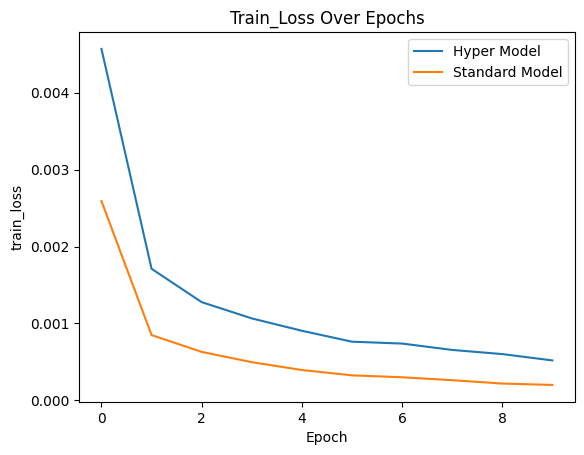

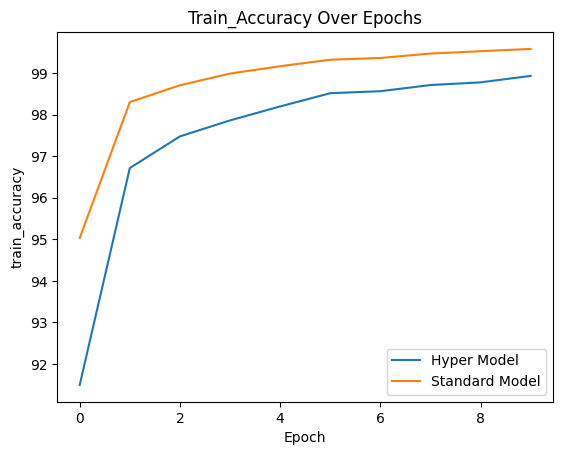

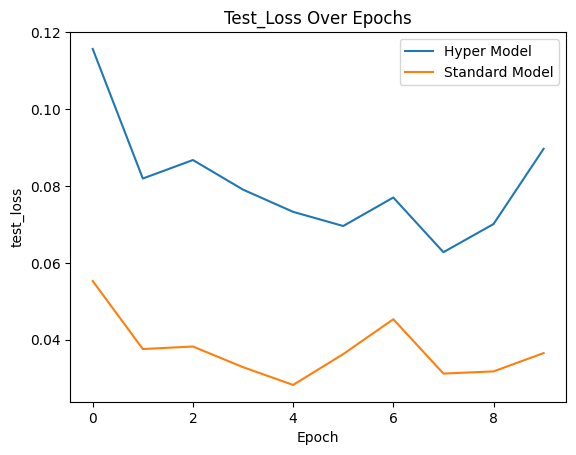

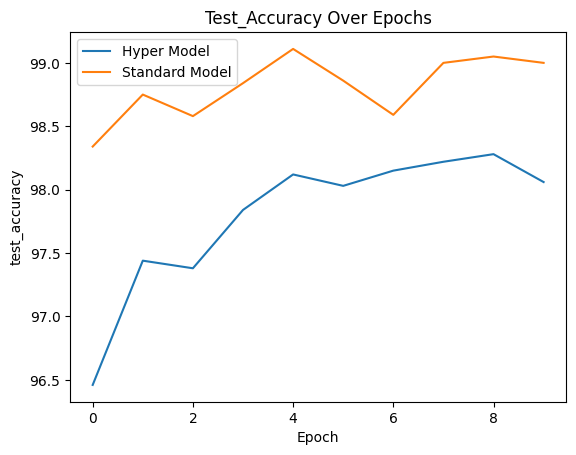

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
(model_hyper, optimizer_hyper), (model_standard, optimizer_standard) = init_models(device)
train_loader, test_loader = load_data()  # Предполагается, что load_data() определена где-то в другом месте
results = run_epochs(model_hyper, optimizer_hyper, model_standard, optimizer_standard, train_loader, test_loader)

for metric in ["train_loss", "train_accuracy", "test_loss", "test_accuracy"]:
    plot_results(results, metric)

## Categorisation of Hypernetworks

Istnieje podział na 5 kryteriów projektowania hipersieci:
- input-based 
- output-based
- variability of inputs 
- variability of outputs
- architecture-based

Za pomocą każdego z nich możemy lepiej zrozumieć działanie konkretnej hipersieci odpowiadając na pytania:

![categorisation.png](./imgs/categorisation.png)

### Input-based hypernetworks

Hypernetworki przyjmują wektor kontekstowy jako dane wejściowe i generują wagi docelowej sieci DNN jako wyjście. W zależności od użytego wektora kontekstowego możemy wyróżnić następujące typy hypernetworks:

- **Task-conditioned hypernetworks**: Te sieci przyjmują informacje specyficzne dla zadania jako dane wejściowe. Sieć generuje wagi dostosowane do konkretnego zadania, co pozwala na dostosowanie jej zachowania i współdzielenie informacji między zadaniami.

- **Data-conditioned hypernetworks**: Te sieci są warunkowane danymi, na których szkolona jest docelowa sieć. Sieć generuje wagi na podstawie charakterystyki danych wejściowych, co pozwala na dynamiczną adaptację modelu do konkretnych wzorców lub cech.

- **Noise-conditioned hypernetworks**: Te sieci nie są warunkowane żadnymi danymi wejściowymi ani wskazówkami zadania, a raczej losowo wybranym szumem. Sprawia to, że są bardziej uniwersalne i pomagają w kwantyfikacji niepewności predykcyjnej dla DNN.

### Output-based Hypernetworks

W zależności od sposobu generowania wag, czyli strategii generacji wag, klasyfikujemy hypernetworki na te, które generują wszystkie wagi naraz, i te, które tego nie robią. 

- **Generate Once**: Te sieci generują wagi całej docelowej sieci DNN naraz. Wszystkie wygenerowane wagi są używane, a wagi każdej warstwy są generowane razem.

- **Generate Multiple**: Te sieci mają wiele głów????? do produkcji wag i ta metoda generowania wag może uzupełniać inne podejścia. Upraszcza to złożoność i redukuje liczbę wag wymaganych w ostatniej warstwie hypernetwork przez liczbę głów.

- **Generate Chunk-wise**: Sieci tego typu generują wagi docelowej sieci w częściach. Może to prowadzić do niewykorzystania niektórych wygenerowanych wag, ponieważ są one produkowane zgodnie z rozmiarem części, który może nie odpowiadać rozmiarom warstw.

- **Generate Component-wise**: Ta strategia na oddzielnym tworzeniu wag dla każdego indywidualnego komponentu modelu docelowego. Jest to pomocne w generowaniu specyficznych wag, ponieważ różne warstwy lub kanały reprezentują różne cechy lub wzorce w sieci. Jednak podobnie jak w podejściu chunk-wise, sieci hypernetwork składowe wymagają osadzenia dla każdego komponentu, aby odróżnić różne komponenty i wytworzyć wagi specyficzne dla danego komponentu. 


### Variability of Inputs

Możemy kategoryzować hipernety na podstawie zmienności danych wejściowych.

- **Static Inputs**: Jeśli Dane wejściowe są predefiniowane i są stałe, hypernet jest nazywany statycznym w odniesieniu do danych wejściowych.


- **Dynamic Inputs**: Jeśli Dane wejściowe zmieniają się i generalnie zależą od danych, na których trenowana jest sieć docelowa, następnie hypernet jest nazywany dynamicznym w odniesieniu do danych wejściowych. 

### Variability of Outputs

Klasyfikując sieci hypernetwork na podstawie charakterystyki wag sieci docelowej, możemy podzielić je na dwa typy: statyczne i dynamiczne wyjścia.

- **Static Outputs**: Jeśli wagi sieci docelowej mają stały rozmiar, to sieć hypernetwork nazywana jest statyczną względem wyjść. W takim przypadku sieć docelowa również jest statyczna.

- **Dynamic Outputs**: Jeśli wagi sieci docelowej nie są stałe, architektura zmienia się w zależności od rozmiaru, to sieć hypernetworku nazywana jest dynamiczną względem wyjść, a sieć docelowa również jest siecią dynamiczną, ponieważ może mieć różną architekturę w zależności od wejścia sieci hypernetwork.

### Dynamism in Hypernetworks

- **Static Hypernets**: Jeśli wejście sieci hypernetwork jest stałe, a liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest stała, wówczas sieć hypernetwork nazywana jest statyczną.

- **Dynamic Hypernets**: Jeśli wejście sieci hypernetwork opiera się na danych wejściowych sieci docelowej lub liczba wag generowanych przez sieć hypernetwork dla sieci docelowej jest zmienna, wówczas sieć hypernetwork nazywana jest dynamiczną.

### Architecture of Hypernetworks

W klasyfikacji sieci hypernetwork na podstawie ich architektury możemy wyróżnić cztery główne typy:

- **MLPs**: Sieci hypernetwork oparte na MLP wykorzystują gęstą i w pełni połączoną architekturę, co pozwala na kompleksowe generowanie wag, biorąc pod uwagę całą informację wejściową.

- **CNNs**: Sieci hypernetwork oparte na CNN wykorzystują warstwy konwolucyjne do przechwytywania lokalnych wzorców i informacji przestrzennych, co sprawia, że są one skuteczne w zadaniach związanych z danymi przestrzennymi, takimi jak analiza obrazów czy wideo.

- **RNNs**: Sieci hypernetwork oparte na RNN zawierają rekurencyjne połączenia w swojej architekturze, co umożliwia przetwarzanie informacji sekwencyjnych i dynamiczne generowanie wag na podstawie poprzednich stanów lub danych wejściowych, co czyni je odpowiednimi dla zadań związanych z danymi sekwencyjnymi.

- **Attention-based hypernetworks**: Sieci hypernetwork oparte na mechanizmach uwagi selektywnie koncentrują się na istotnych cechach wejściowych, generując wagi dla sieci docelowej, co pozwala im uchwycić dalekosiężne zależności i poprawić jakość generowanych wyjść.
